In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import math
import pickle as pkl
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/PDFs")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/DetResponse")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/Utils")

from Detector import *
from Signal import *
from Plot_Histogram import *
from Background import *
from Plot_Histogram import *
from Utils import *

from modeling import PdfBase, Model, Parameter
from data import DataSet
from llh import LikelihoodRatioTest
import matplotlib.pyplot as plt

In [2]:
# Signal pdf:
channel = "WW"
mass = 100
profile='NFW'
xsec = 1e-23
# Bin
if mass<=3000:
    Bin = Std_Binning(mass, N_Etrue=100)
else:
    Bin = Std_Binning(3000, N_Etrue=800)

Reco = RecoRate(channel, mass, profile, Bin, type="Resp", set='1122', spectra='Charon')
DMRate = Reco.ComputeRecoRate()

Reco.Scramble = True
Reco.hist['Resp'] = None
DMRateScr = Reco.ComputeRecoRate()


********************
Buiding final reco rate using Resp method
********************
Computing true rate with Charon spectra
channel: WW || mass: 100 || profile: NFW || process: ann

********************
Computing Spectra
Initial Flux Loading: /home/tchau/.local/lib/python3.10/site-packages/charon-0.1.0-py3.10.egg/charon/data/Spectra_PYTHIA.hdf5
********************
Computing Jfactor with default option: precomputed Clumpy file
********************
Computing Response Matrix
********************
Accessing MC set 1122
********************
Buiding final reco rate using Resp method
********************
True rate already computed, will not compute it again
********************
Computing Response Matrix
********************
Accessing MC set 1122


In [3]:
# Background
exposure = 8* 365.*24.* 60.* 60.
BkgPDF = ScrambleBkg(Bin, bw="ISJ", oversample=10)
BurnSample = DataHist(Bin)
Ndata = 10* np.sum(BurnSample)
BkgRate = 10*np.sum(BurnSample)*BkgPDF/(np.sum(BkgPDF))/(exposure)

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2012_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2013_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2014_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2015_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2016_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2017_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscN

In [4]:
#  Galactic astro flux
GCRate = GC_RecoRate(Bin, method='evtbyevt', set='1122', scrambled=False)[0]
GCRateScr = GC_RecoRate(Bin, method='evtbyevt', set='1122', scrambled=True)[0]


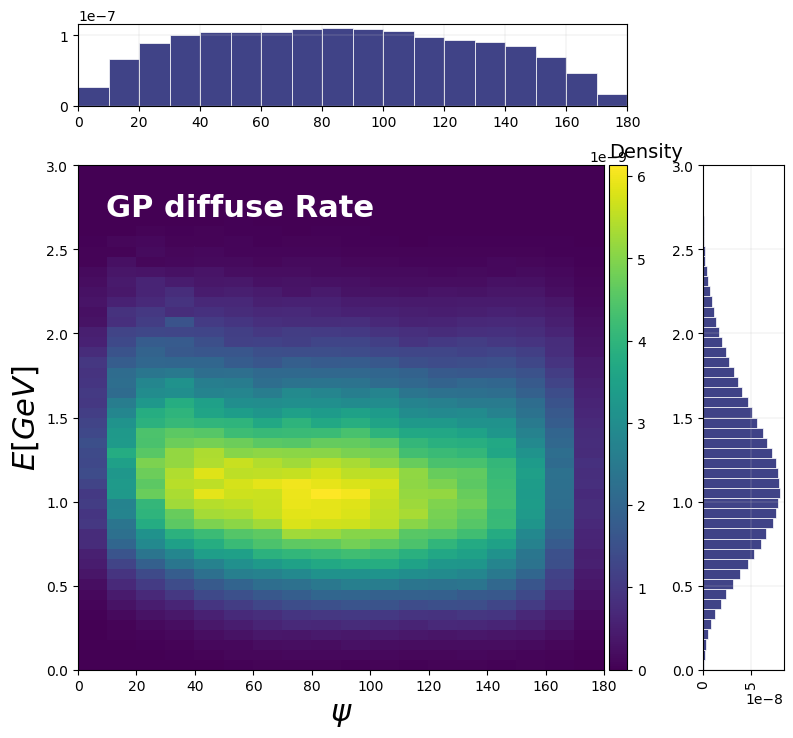

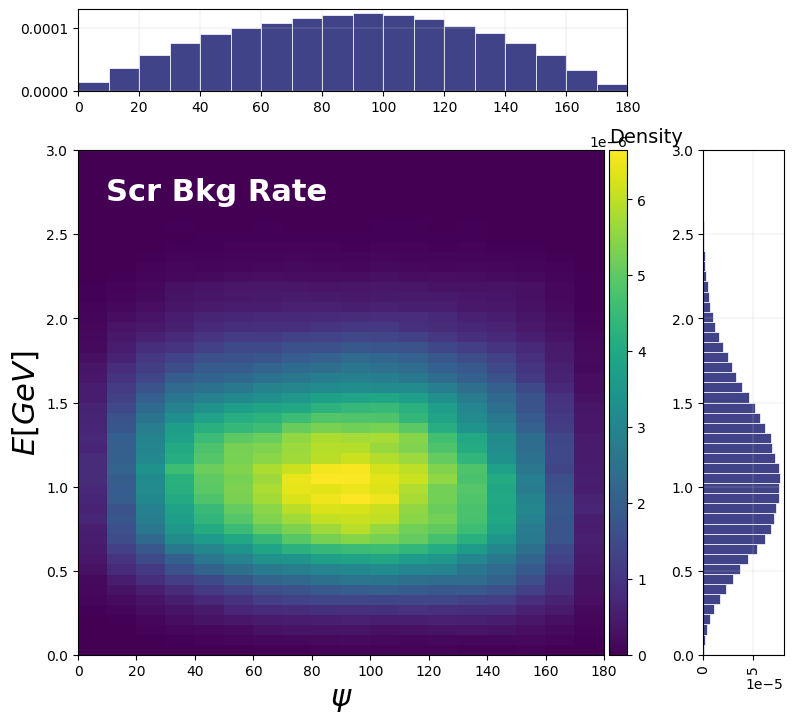

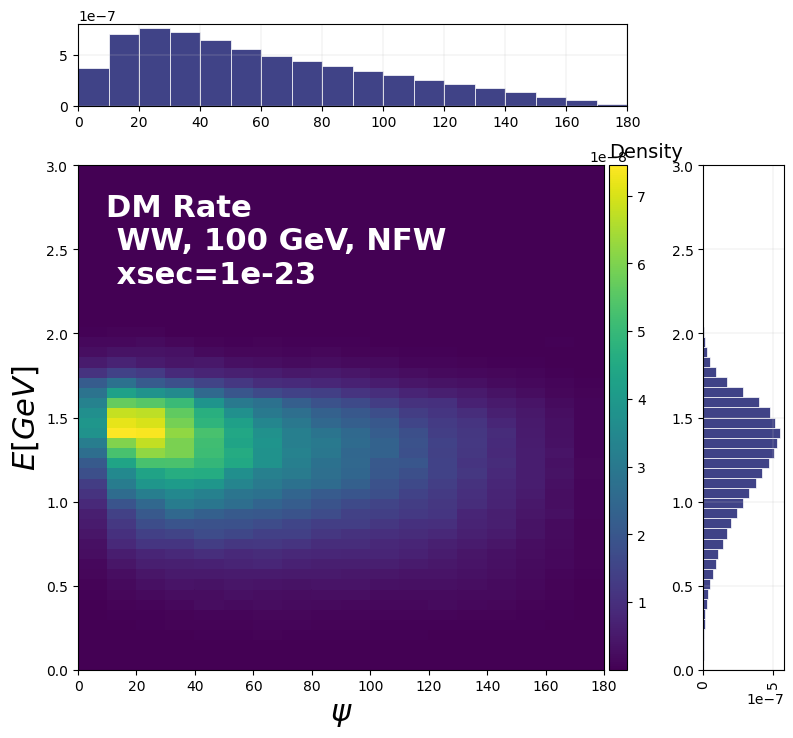

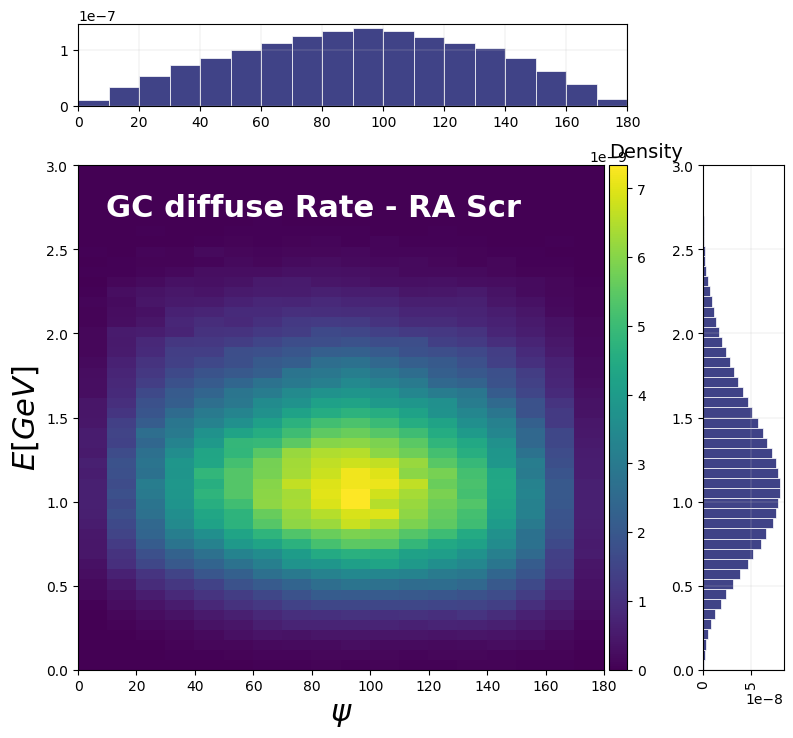

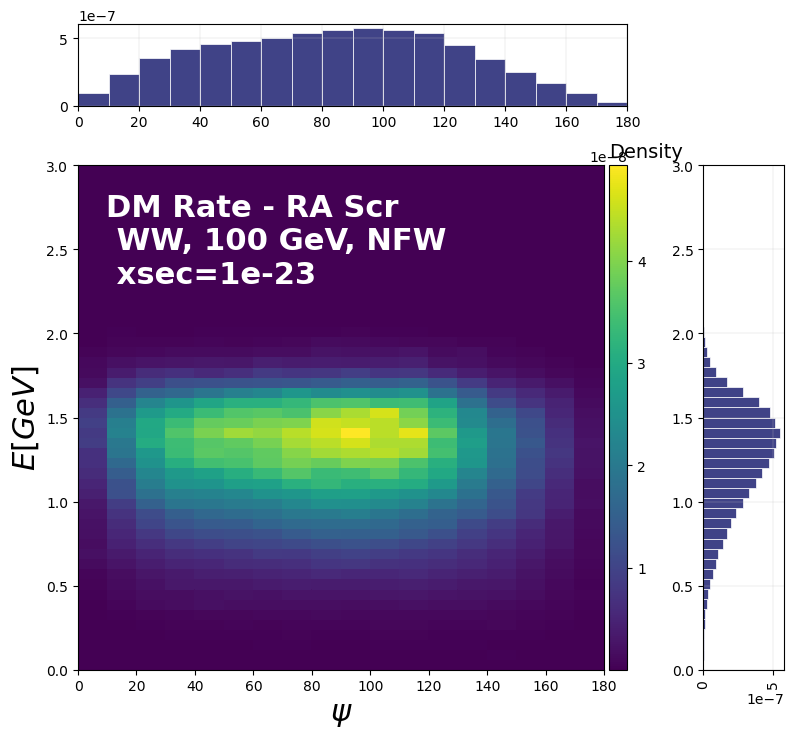

In [5]:
plot_projections(GCRate, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'GP diffuse Rate', norm=None, min=None, zlogscale=False)
plot_projections(BkgRate, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'Scr Bkg Rate', norm=None, min=None, zlogscale=False)
plot_projections(DMRate* xsec, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'DM Rate \n {}, {} GeV, {} \n xsec={}'.format(channel, mass, profile, xsec), norm=None, min=None, zlogscale=False)
plot_projections(GCRateScr, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'GC diffuse Rate - RA Scr', norm=None, min=None, zlogscale=False)
plot_projections(DMRateScr* xsec, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'DM Rate - RA Scr \n {}, {} GeV, {} \n xsec={}'.format(channel, mass, profile, xsec), norm=None, min=None, zlogscale=False)


In [6]:
# Expected number of events in 8 years of OscNext
print("N GC astro: {}".format(np.sum(GCRate)* exposure))
print("N DM: {}".format(np.sum(DMRate* xsec)* exposure))
print("N Bkg: {}".format(np.sum(BkgRate)* exposure))

N GC astro: 385.52793025375985
N DM: 1683.7565796374392
N Bkg: 366379.9999999999


[]

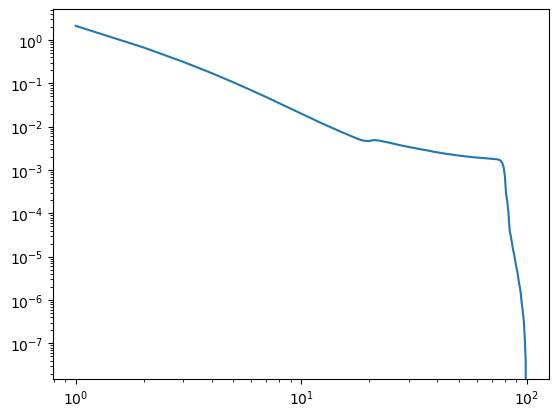

In [7]:
plt.plot(Bin['true_energy_center'] ,Reco.hist['Spectra']['nu_e'])
plt.semilogx()
plt.semilogy()

# Include GC component in the model

In [8]:
# Create the PDF object
SignalPDF = PdfBase(DMRate.flatten()/np.sum(DMRate.flatten()), name="SignalPDF")
ScrSignalPDF = PdfBase(DMRateScr.flatten()/np.sum(DMRateScr.flatten()), name="ScrSignalPDF")
GCPDF = PdfBase(GCRate.flatten()/np.sum(GCRate.flatten()), name="GC")
ScrGCPDF = PdfBase(GCRateScr.flatten()/np.sum(GCRateScr.flatten()), name="GCScr")

# Assuming the Scr Bkg from burn sample is the atm Bkg
BkgPDF = PdfBase(BkgRate.flatten()/np.sum(BkgRate.flatten()), name="BkgAtm")

# The data with the assumption of signal fraction xi_true and galactic fraction gc_true:
xi_true = np.sum(DMRate*xsec*exposure)/(Ndata)
gc_true = np.sum(GCRate)*exposure/Ndata

dm_inj = Parameter(value=xi_true, limits=(0,1), fixed=True, name="dm_inj")
gc_inj = Parameter(value=gc_true, limits=(0,1), fixed=True, name="gc_inj")

pseudo_data = dm_inj* SignalPDF + gc_inj* GCPDF + (1-dm_inj-gc_inj)* BkgPDF
# pseudo_data = dm_inj* SignalPDF + (1-dm_inj)* BkgPDF


# Scramble bkg now yields:
ScrBkgPDF = dm_inj* ScrSignalPDF + gc_inj* ScrGCPDF + (1-dm_inj-gc_inj)* BkgPDF
# ScrBkgPDF = dm_inj* ScrSignalPDF + (1-dm_inj)* BkgPDF



Parameter dm_inj already exists in the model, it won't be added again
Parameter gc_inj already exists in the model, it won't be added again
Parameter dm_inj already exists in the model, it won't be added again
Parameter gc_inj already exists in the model, it won't be added again


In [9]:
dm_H1 = Parameter(value=xi_true, limits=(0,1), fixed=False, name="dm_H1")
gc_H1 = Parameter(value=gc_true, limits=(gc_true* (1.-0.002), gc_true* (1.+0.002)), fixed=True, name="gc_H1")
dm_H0 = Parameter(value=xi_true, limits=(0,1), fixed=True, name="dm_H0")
gc_H0 = Parameter(value=gc_true, limits=(0,1), fixed=True, name="gc_H0")

# # Poisson:
# modelH0 = dm_fix* SignalPDF + gc_fix* GCPDF + (1-dm_fix-gc_fix)* ScrBkgPDF
# modelH1 = dm_fit* SignalPDF + gc_fit* GCPDF + (1-dm_fit-gc_fit)* ScrBkgPDF

# SignalSub:
# Poisson:
modelH0 = dm_H0* SignalPDF + gc_H0* GCPDF + ScrBkgPDF - dm_H0* ScrSignalPDF - gc_H0* ScrGCPDF
modelH1 = dm_H1* SignalPDF + gc_H1* GCPDF + ScrBkgPDF - dm_H1* ScrSignalPDF - gc_H1* ScrGCPDF

# modelH0 = dm_H0* SignalPDF + ScrBkgPDF - dm_H0* ScrSignalPDF
# modelH1 = dm_H1* SignalPDF + ScrBkgPDF - dm_H1* ScrSignalPDF

lr = LikelihoodRatioTest(model = modelH1, null_model = modelH0)

ds = DataSet()
ds.asimov(Ndata, pseudo_data)

PDF ScrSignalPDF already exists in the model, it won't be added again
Parameter dm_H0 already exists in the model, it won't be added again
PDF GCScr already exists in the model, it won't be added again
Parameter gc_H0 already exists in the model, it won't be added again
PDF ScrSignalPDF already exists in the model, it won't be added again
Parameter dm_H1 already exists in the model, it won't be added again
PDF GCScr already exists in the model, it won't be added again
Parameter gc_H1 already exists in the model, it won't be added again


In [10]:
print(modelH1)

 Model: dm_H1*SignalPDF + gc_H1*GC + dm_inj*ScrSignalPDF + gc_inj*GCScr + (1-dm_inj - gc_inj) * BkgAtm - dm_H1*ScrSignalPDF - gc_H1*GCScr
 Number of pdf: 5
 - SignalPDF
 - GC
 - ScrSignalPDF
 - GCScr
 - BkgAtm
 Number of parameters: 4
 Name: dm_H1, Value: 0.00, Scale: 1.0e+00, Limits: (0.0, 1.0), Fixed: False, Is nuisance? False
 Name: gc_H1, Value: 0.00, Scale: 1.0e+00, Limits: (0.0, 0.0), Fixed: True, Is nuisance? False
 Name: dm_inj, Value: 0.00, Scale: 1.0e+00, Limits: (0.0, 1.0), Fixed: True, Is nuisance? False
 Name: gc_inj, Value: 0.00, Scale: 1.0e+00, Limits: (0.0, 1.0), Fixed: True, Is nuisance? False


In [11]:
# now do simple fit:
lr.data = ds
lr.fit("H1")
print(lr.models['H1'].parameters["dm_H1"].value)
print(lr.models['H1'].parameters["gc_H1"].value)


/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/RHEL_7_x86_64/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


0.004577351922362638
0.0010522624877279322


In [12]:
print(pseudo_data.parameters["dm_inj"].value)
print(pseudo_data.parameters["gc_inj"].value)
print(lr.models['H0'].parameters["dm_H0"].value)
print(lr.models['H0'].parameters["gc_H0"].value)

0.004595656366716085
0.0010522624877279322
0.004595656366716085
0.0010522624877279322


In [13]:
# signal recovery:
xi_inj = np.linspace(0., 0.005, 50)
xi_fit = np.array([])
ng_fit = np.array([])

# lr.models['H1'].parameters["gc_fit"].fixed = False
# lr.models['H1'].parameters["gc_H1"].fixed = True
# pseudo_data.parameters["gc_inj"].value = 0.001
# lr.models['H1'].parameters["gc_fit"].value = pseudo_data.parameters["gc_inj"].value

for x in xi_inj:
    pseudo_data.parameters["dm_inj"].value = x
    lr.models['H1'].parameters["dm_inj"].value = x

    ds.asimov(Ndata, pseudo_data)
    lr.data = ds
    lr.fit("H1")
    xi_fit = np.append(xi_fit, lr.models['H1'].parameters["dm_H1"].value)
    ng_fit = np.append(ng_fit, lr.models['H1'].parameters["gc_H1"].value)


/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/RHEL_7_x86_64/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


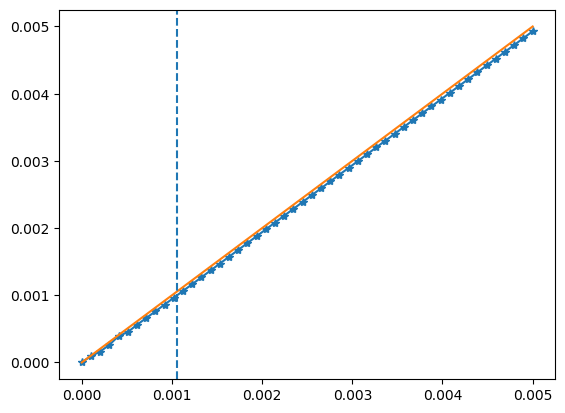

In [14]:
plt.plot(xi_inj, xi_fit, marker='*')
plt.plot(xi_inj, xi_inj)
plt.axvline(x=pseudo_data.parameters["gc_inj"].value, ls='--')

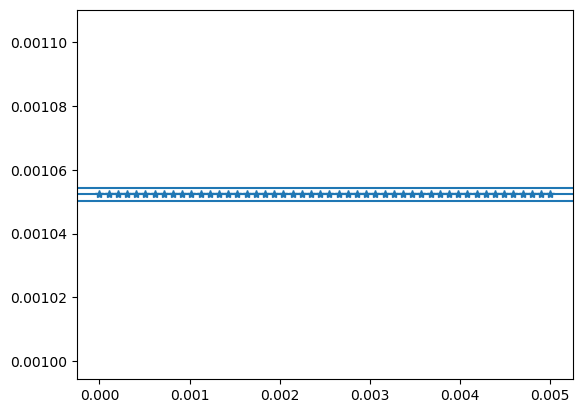

In [15]:
plt.plot(xi_inj, ng_fit, marker='*')
plt.axhline(y=pseudo_data.parameters["gc_inj"].value)
plt.axhline(y=pseudo_data.parameters["gc_inj"].value*(1-0.002))
plt.axhline(y=pseudo_data.parameters["gc_inj"].value*(1+0.002))


# Fix the GC component

In [16]:
#  if GC is not included in the fit:
# signal recovery:
xi_inj = np.linspace(0., 0.002, 50)
xi_fit = np.array([])
ng_fit = np.array([])

# pseudo_data.parameters["gc_inj"].value = np.sum(GCRate)* exposure/Ndata
pseudo_data.parameters["gc_inj"].value = 0

lr.models['H1'].parameters["gc_H1"].fixed = True
lr.models['H1'].parameters["gc_H1"].value = np.sum(GCRate* exposure)/Ndata
lr.models['H1'].parameters["gc_inj"].fixed = True
lr.models['H1'].parameters["gc_inj"].value = np.sum(GCRate* exposure)/Ndata

# lr.models['H1'].parameters["gc_H1"].value = 0.

for x in xi_inj:
    pseudo_data.parameters["dm_inj"].value = x
    lr.models['H1'].parameters["dm_inj"].value = x

    ds.asimov(Ndata, pseudo_data)
    lr.data = ds
    lr.fit("H1")
    xi_fit = np.append(xi_fit, lr.models['H1'].parameters["dm_H1"].value)

    # ng_fit = np.append(ng_fit, lr.models['H1'].parameters["gc_fit"].value)

/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/RHEL_7_x86_64/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Text(0.5, 1.0, 'WW, 100 GeV, NFW')

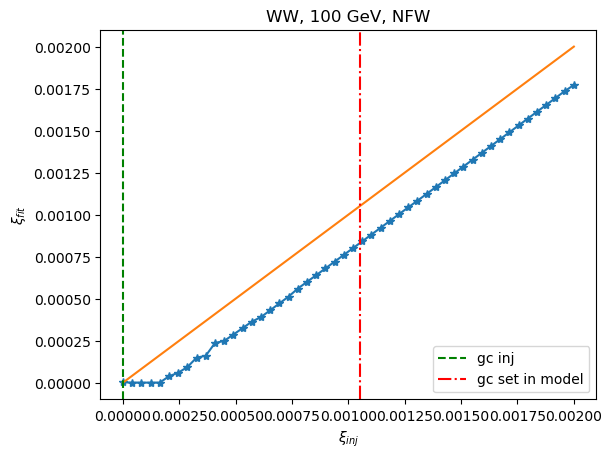

In [17]:
plt.plot(xi_inj, xi_fit, marker='*')
plt.plot(xi_inj, xi_inj)
plt.axvline(x=pseudo_data.parameters["gc_inj"].value, ls='--', c='green', label='gc inj')
plt.axvline(x=lr.models['H1'].parameters["gc_H1"].value, ls='-.', c='red', label='gc set in model')
plt.legend()
plt.xlabel(r'$\xi_{inj}$')
plt.ylabel(r'$\xi_{fit}$')
plt.title('{}, {} GeV, {}'.format(channel, mass, profile))